In [1]:
pip install tensorflow keras opencv-python matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import re
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define constants
IMAGE_SIZE = (224, 224)
DATASET_PATH = r'D:\Internproj\imdb_crop'
classes = 100  # Adjust based on your dataset
BATCH_SIZE = 1000  # Process 1000 images at a time

# Regular expression to match and extract birth year and photo year
filename_regex = re.compile(r'_(\d{4})-\d+-\d+_(\d{4})\.jpg')

def calculate_age(birth_year, photo_year):
    return photo_year - birth_year

def load_images_and_ages_batch(dataset_path, start_index, batch_size):
    images = []
    ages = []
    files = []

    # Walk through all directories and collect image paths
    for root, dirs, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                files.append(os.path.join(root, filename))

    for i in range(start_index, min(start_index + batch_size, len(files))):
        filename = files[i]
        match = filename_regex.search(filename)
        if match:
            try:
                birth_year = int(match.group(1))
                photo_year = int(match.group(2))
                age = calculate_age(birth_year, photo_year)
            except (ValueError, IndexError) as e:
                print(f"Warning: Skipping file with unexpected filename format: {filename}")
                continue

            img = cv2.imread(filename)
            if img is None:
                print(f"Warning: Unable to load image at {filename}")
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            img = img / 255.0
            images.append(img)
            ages.append(age)
        else:
            print(f"Warning: Skipping file with unexpected filename format: {filename}")

    images = np.array(images)
    ages = np.array(ages)
    ages = to_categorical(ages, num_classes=classes)

    return images, ages

# Example of loading a batch
start_index = 0
images, ages = load_images_and_ages_batch(DATASET_PATH, start_index, BATCH_SIZE)

print(f"Batch {start_index//BATCH_SIZE + 1}: Loaded {len(images)} images and labels.")


Batch 1: Loaded 1000 images and labels.


Images shape: (1000, 224, 224, 3)
Ages shape: (1000, 100)


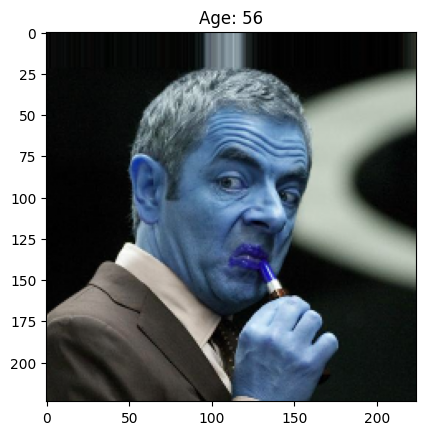

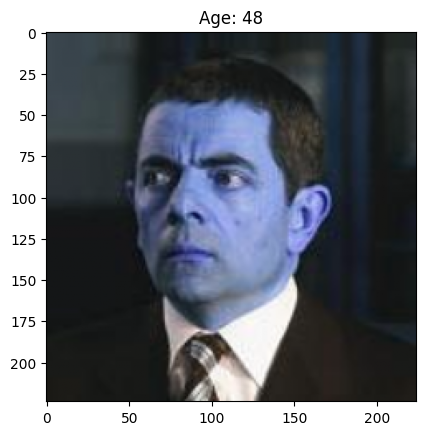

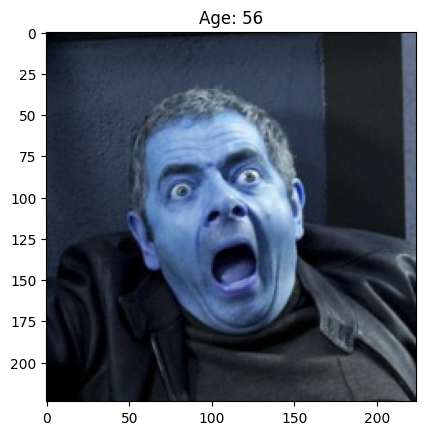

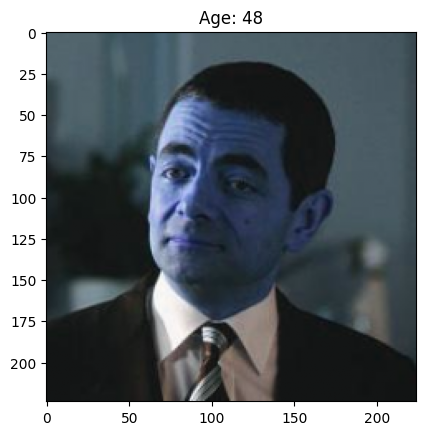

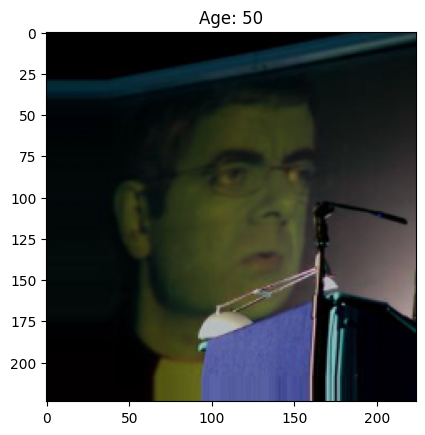

In [5]:
# Print shapes of the loaded data
print(f"Images shape: {images.shape}")
print(f"Ages shape: {ages.shape}")

# Display a few sample images and their labels
import matplotlib.pyplot as plt

for i in range(5):  # Display first 5 images
    plt.imshow(images[i])
    plt.title(f"Age: {np.argmax(ages[i])}")
    plt.show()


In [17]:
print(f"Dataset path: {DATASET_PATH}")


Dataset path: ./imdb_crop


In [6]:
start_index = 1000  # Start where the last batch ended
images, ages = load_images_and_ages_batch(DATASET_PATH, start_index, BATCH_SIZE)


In [7]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, ages, test_size=0.2, random_state=42)


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the convolutional layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.0626 - loss: 5.3235 - val_accuracy: 0.0900 - val_loss: 4.0559
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.1250 - loss: 3.8670 - val_accuracy: 0.1250 - val_loss: 3.7512
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.1490 - loss: 3.4825 - val_accuracy: 0.1250 - val_loss: 3.5461
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.1556 - loss: 3.2623 - val_accuracy: 0.1600 - val_loss: 3.5309
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.2258 - loss: 3.0153 - val_accuracy: 0.1500 - val_loss: 3.4442
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.2552 - loss: 2.8362 - val_accuracy: 0.1550 - val_loss: 3.3313
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.2811 - loss: 2.5901 - val_accuracy: 0.1650 - val_loss: 3.3151
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.3374 - loss: 2.4169 - val_accuracy: 0.2050 - val_loss:

In [9]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Optionally, unfreeze some layers and fine-tune
for layer in base_model.layers[-4:]:  # Example: unfreeze last 4 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.2490 - loss: 3.2538
Validation Loss: 3.32143497467041, Validation Accuracy: 0.22499999403953552
Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.4119 - loss: 2.0202 - val_accuracy: 0.2300 - val_loss: 3.3033
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.4762 - loss: 1.7572 - val_accuracy: 0.2300 - val_loss: 3.3093
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5015 - loss: 1.6400 - val_accuracy: 0.2250 - val_loss: 3.2697
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.5002 - loss: 1.6517 - val_accuracy: 0.2200 - val_loss: 3.3267
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.5003 - loss: 1.6242 - val_accuracy: 0.2350 - val_loss: 3.3323


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


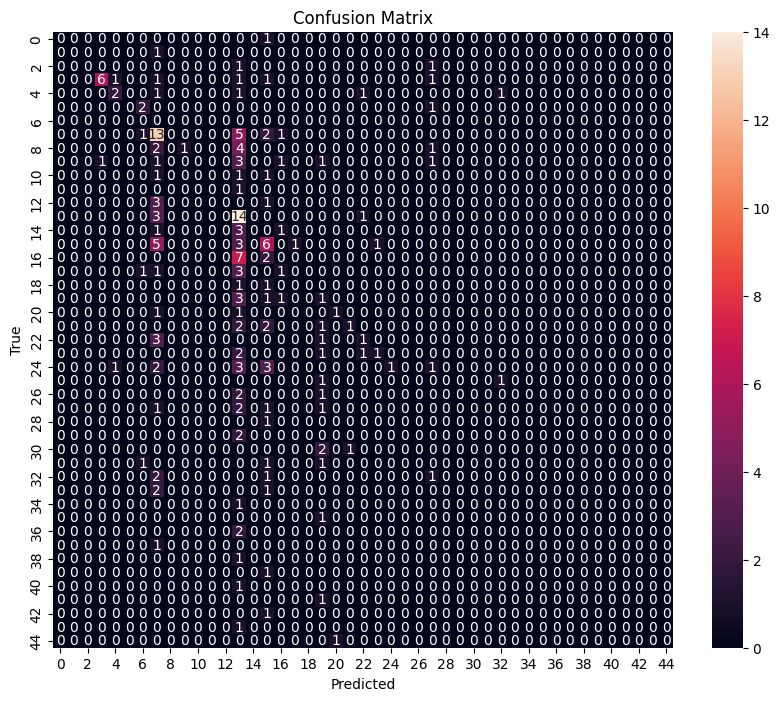

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
model.save('age_detection_model.keras')


In [20]:
img_path = r'D:\Internproj\imdb_crop\00\nm0000100_rm96704768_1955-1-6_2003.jpg'  # Ensure this is a valid path


In [21]:
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Unable to load image at {img_path}. Please check the file path and format.")


In [22]:
print(f"Original image shape: {img.shape}")


Original image shape: (183, 183, 3)


In [23]:
print(f"Resizing image to: {IMAGE_SIZE}")


Resizing image to: (224, 224)


In [25]:
import cv2
import numpy as np

# Define constants
IMAGE_SIZE = (224, 224)  # Example size, adjust as needed

# Path to new image
img_path = r'D:\Internproj\imdb_crop\00\nm0000100_rm96704768_1955-1-6_2003.jpg'  # Ensure this path is correct

# Load and preprocess the image
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Unable to load image at {img_path}. Please check the file path and format.")

print(f"Original image shape: {img.shape}")

try:
    img = cv2.resize(img, IMAGE_SIZE)
except Exception as e:
    raise RuntimeError(f"Error resizing image: {e}")

img = img / 255.0
img = np.expand_dims(img, axis=0)

# Load the model
from tensorflow.keras.models import load_model
model = load_model('age_detection_model.h5')

# Predict age
prediction = model.predict(img)
predicted_age = np.argmax(prediction)
print(f"Predicted Age: {predicted_age}")


Original image shape: (183, 183, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Predicted Age: 37


In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes))


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
              precision    recall  f1-score   support

          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         2
          18       0.86      0.55      0.67        11
          20       0.50      0.33      0.40         6
          21       0.00      0.00      0.00         3
          22       0.00      0.00      0.00         0
          23       0.29      0.59      0.39        22
          24       0.00      0.00      0.00         8
          25       0.00      0.00      0.00         8
          26       0.00      0.00      0.00         3
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         4
          29       0.20      0.78      0.31        18
          31       0.00      0.00      0.00         5
          32       0.21      0.38      0.27        16
          33       0.00      0.00      0.00 

C:\Users\okays\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\okays\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\okays\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:15

In [27]:
for layer in base_model.layers[-4:]:  # Example: unfreeze the last 4 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.5150 - loss: 1.6180 - val_accuracy: 0.2350 - val_loss: 3.3845
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5379 - loss: 1.5115 - val_accuracy: 0.2400 - val_loss: 3.3279
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4880 - loss: 1.6610 - val_accuracy: 0.2250 - val_loss: 3.3435
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.5475 - loss: 1.4569 - val_accuracy: 0.2400 - val_loss: 3.3759
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.5524 - loss: 1.4620 - val_accuracy: 0.2350 - val_loss: 3.3841
